### Importações das bibliotecas


In [60]:
import datetime

# serialização de dados
import pickle

# tratamento e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# divisão em folds, feature scaling, feature selection e feature encoding
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE

# métricas de performance de modelos
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, precision_recall_fscore_support

# importando RandomForestClassifier e GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# importando o classificador XGBoost
from xgboost import XGBClassifier

# Para a Validação Cruzada
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Tunagem de Hiperparâmetros
import optuna
import optuna.logging
# Definindo que apenas os avisos serão exibidos, para evitar spam nos outputs.
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Importando a base de dados

In [3]:
with open('EDA_df.pkl', mode='rb') as f:
    df = pickle.load(f)

### Funções que utilizaremos

Criaremos as seguintes features:
 1. retorno_emprestimo = multiplicando (taxa_juros_emprestimo por valor_emprestimo) + valor_empréstimo;
 2. ratio_renda_emp = dividindo renda por emprestimo;
 3. ratio_emprego_credito = tempo_emprego_cliente dividido por tempo_credito_cliente, caso dividir por zero, resulta em zero;
 4. media_valemp_nota = média de valor_emprestimo para cada nota_emprestimo;
 5. media_valoremp_finalidade = média de valor_emprestimo para cada finalidade_emprestimo;
 6. std_valemp_residencia = desvio-padrão do valor_emprestimo por posse_residencia_cliente;
 7. media_renda_nota = média de renda_cliente para cada nota_emprestimo;
 8. media_renda_finalidade = média de renda_cliente para cada finalidade_emprestimo;
 9. std_renda_residencia = desvio-padrão do renda_cliente por posse_residencia_cliente;
10. ratio_emprego_renda = tempo_emprego_cliente dividido por renda_cliente
11. ratio_credito_renda = tempo_credito_cliente dividido por renda_cliente

In [4]:
# faz o Feature Engineering de um pandas DataFrame
def feature_engineering(df: pd.DataFrame,
                        features: list=None
                        ) -> pd.DataFrame:
    # 1. 
    df['retorno_emprestimo'] = df['valor_emprestimo'] * (df['taxa_juros_emprestimo'] / 100 + 1)
    # 2.
    df['ratio_renda_emp'] = df['renda_cliente'] / df['valor_emprestimo']
    # 3. 
    df['ratio_emprego_credito'] = df['tempo_emprego_cliente'] / df['tempo_credito_cliente']
    # 4.
    df['media_valemp_nota'] = df.groupby(['nota_emprestimo'])['valor_emprestimo'].transform('mean')
    # 5.
    df['media_valemp_finalidade'] = df.groupby(['finalidade_emprestimo'])['valor_emprestimo'].transform('mean')
    # 6.
    df['std_valemp_residencia'] = df.groupby(['posse_residencia_cliente'])['valor_emprestimo'].transform('std')
    # 7.
    df['media_renda_nota'] = df.groupby(['nota_emprestimo'])['renda_cliente'].transform('mean')
    # 8.
    df['media_renda_finalidade'] = df.groupby(['finalidade_emprestimo'])['renda_cliente'].transform('mean')
    # 9.
    df['std_renda_residencia'] = df.groupby(['posse_residencia_cliente'])['renda_cliente'].transform('std')
    # 10.
    df['ratio_emprego_renda'] = df['tempo_emprego_cliente'] / df['renda_cliente']
    # 11.
    df['ratio_credito_renda'] = df['tempo_credito_cliente'] / df['renda_cliente']
    
    if features:
        return df[features]
    else:
        return df

Ficaremos com 23 colunas no total, 11 a mais do que o dataset original.

In [85]:
# Feature Engineering,
# Treina o modelo, 
# exibe precisão/recall/f1-score,
# matriz de confusão,
# feature_importance e 
# retorna o modelo treinado, X_test, y_test, y_pred
def treinar_modelo(modelo,
                   X: pd.DataFrame,
                   y: pd.Series,
                   metrics_report: bool=False,
                   feature_importance_report: bool=False,
                   features_especificas: list=None,
                   input_threshold: float=False
                   ) -> Pipeline:      
    # Criando o StratifiedKFold com 10 folds
    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=47)

    # Definimos quais são as features categóricas
    cat_features = ['posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo']

    # Definindo um pipeline com StandardScaler, TargetEncoder e o modelo
    pipeline = Pipeline([
        ('encoder', TargetEncoder(cols=cat_features)),
        ('scaler', StandardScaler()),
        ('modelo', modelo)
    ])

    # Definindo as métricas de avaliação do modelo
    scoring = [
        'precision_weighted',
        'recall_weighted',
        'f1_weighted'
               ]
    
    # Separando os folds
    for train_index, test_index in skf.split(X, y): # train_index, test_index = next(skf.split(X,y))
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        if features_especificas:
            X_train = feature_engineering(X_train, features_especificas)
            X_test = feature_engineering(X_test, features_especificas)
        else:
            X_train = feature_engineering(X_train)
            X_test = feature_engineering(X_test)
    
    # Treinamos a pipeline
    pipeline.fit(X_train, y_train)
    
    
    # se quisermos ajustar o threshold
    if input_threshold:
        # Calculando as métricas usando cross_val_predict
        y_pred_proba = cross_val_predict(pipeline, X, y, cv=skf, method='predict_proba')[:, 1]
        y_pred = np.where(y_pred_proba >= input_threshold, 1, 0)
        
        precisao_limiar, revocacao_limiar, f1_limiar, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
        precisao_auc, revocacao_auc, limiares = precision_recall_curve(y_test, y_pred_proba[test_index])
        
        pr_auc = auc(revocacao_auc, precisao_auc)
    else:
        # Calculando as métricas usando cross_validate
        scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        # Obtemos os resultados da previsão para aplicar nas funções das métricas
        y_pred = pipeline.predict(X_test)
        
        # pr_auc: Precision-Recall Area Under the Curve
        precisao_auc, revocacao_auc, limiares = precision_recall_curve(y_test, y_pred_proba)
        
        pr_auc = auc(revocacao_auc, precisao_auc)
    
            
    # Exibe métricas e matriz de confusão
    if metrics_report:
        if input_threshold:
            print(f"Média da Precisão (Weighted): {precisao_limiar:.2%}")
            print(f"Média da Revocação (Weighted): {revocacao_limiar:.2%}")
            print(f"Média do F1 Score (Weighted): {f1_limiar:.2%}")
            print(f'Precisão x Revocação, Área abaixo da Curva: ({pr_auc:.2%}) -> {pr_auc:.16f}')
            
            # Plotando a matriz de confusão da cross_val_predict
            matriz_confusao = confusion_matrix(y_test, y_pred[test_index])
            
        else:
            # Exibindo as métricas
            print(f"Média da Precisão (Weighted): {scores['test_precision_weighted'].mean():.2%}")
            print(f"Média da Revocação (Weighted): {scores['test_recall_weighted'].mean():.2%}")
            print(f"Média do F1 Score (Weighted): {scores['test_f1_weighted'].mean():.2%}")
            print(f'Precisão x Revocação, Área abaixo da Curva: ({pr_auc:.2%}) -> {pr_auc:.16f}')
    
            # Plotando a matriz de confusão da cross_validate
            matriz_confusao = confusion_matrix(y_test, y_pred)
            
        sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Greens')

        # Configurações do gráfico
        plt.title('Matriz de confusão')
        plt.xlabel('Valor Predito')
        plt.ylabel('Valor Real')
        plt.show();    

    # Exibe a feature importance
    if feature_importance_report:
        if hasattr(pipeline.named_steps['modelo'], 'feature_importances_'):
            feature_importances = pipeline.named_steps['modelo'].feature_importances_
            importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
            importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
            print(importances_df)
    
    if input_threshold:
        return pipeline, X_test, y_test, y_pred[test_index]
    else:
        return pipeline, X_test, y_test, y_pred

In [11]:
# Relatório do Recursive Feature Elimination
def rfe_report(modelo,
               min_range: int=13,
               max_range: int=23
               ) -> list:
    # splitar em treino e teste estratificado
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=47)

    # Definimos quais são as features categóricas
    cat_features = ['posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo']
    
    # Loop sobre os folds do StratifiedKFold para obter os splits estratificados
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        X_train = feature_engineering(X_train)
        X_test = feature_engineering(X_test)
        
        # Instanciamos o Encoder
        encoder = TargetEncoder(min_samples_leaf=450, smoothing=11.5, cols=cat_features)
        
        # Ajustando o encoder apenas ao conjunto de treinamento
        encoder.fit(X_train[cat_features], y_train)
        
        # Aplicamos a transformação tanto no treinamento quanto no teste
        X_train[cat_features] = encoder.transform(X_train[cat_features]).astype(float)
        X_test[cat_features] = encoder.transform(X_test[cat_features]).astype(float)
    
    # instanciamos o RFE
    selector = RFE(estimator=modelo)
    
    # Instanciando variáveis controle da melhor métrica obtida:
    melhor_pr_auc = 0
    
    # iteramos sobre a quantidade de features desejadas para o modelo de 2 em 2
    for qtd_features in range(min_range, max_range, 2):
        # definimos o número de features que devem permanecer
        selector.n_features_to_select = qtd_features

        # Executando RFE no fold de treino
        selector.fit(X_train, y_train)
        features_selecionadas = selector.support_

        # Filtrar as features selecionadas
        X_train_selecionado = X_train.loc[:, features_selecionadas]
        X_test_selecionado = X_test.loc[:, features_selecionadas]

        # Treinar o modelo com as features selecionadas
        modelo.fit(X_train_selecionado, y_train)

        # Prever probabilidades no fold de teste
        y_pred_proba = modelo.predict_proba(X_test_selecionado)[:, 1]

        # Calcular a curva Precision-Recall AUC
        precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
        metrica_pr_auc = auc(revocacao, precisao)
        nome_features_selecionadas = [X_train.columns[i] for i, item in enumerate(features_selecionadas) if item]  
        
        # Comparando e atualizando as informações do melhor resultado encontrado
        if metrica_pr_auc > melhor_pr_auc:         
            melhor_modelo_n_features = qtd_features
            melhores_features = nome_features_selecionadas.copy()
            melhor_pr_auc = metrica_pr_auc
    
        # exibe as informações do RFE atual
        print('----------------------------------------------')
        print(f'RFE {qtd_features} features - [INFO] Precision Recall AUC: ', metrica_pr_auc)
    # exibe as informações do melhor RFE
    print('----------------------------------------------')
    print(f'MELHOR "X_train" com {melhor_modelo_n_features} features:')
    print('[END] Precision Recall AUC: ', melhor_pr_auc)
    print("[END] Features selecionadas: ", melhores_features)
    
    # retorna as features que obtiveram a melhor métrica
    return melhores_features

# Modelagem
### Feature Engineering
Utilizaremos:
- Médias e desvios-padrão de features; e
- ratios: divisão de uma feature por outra

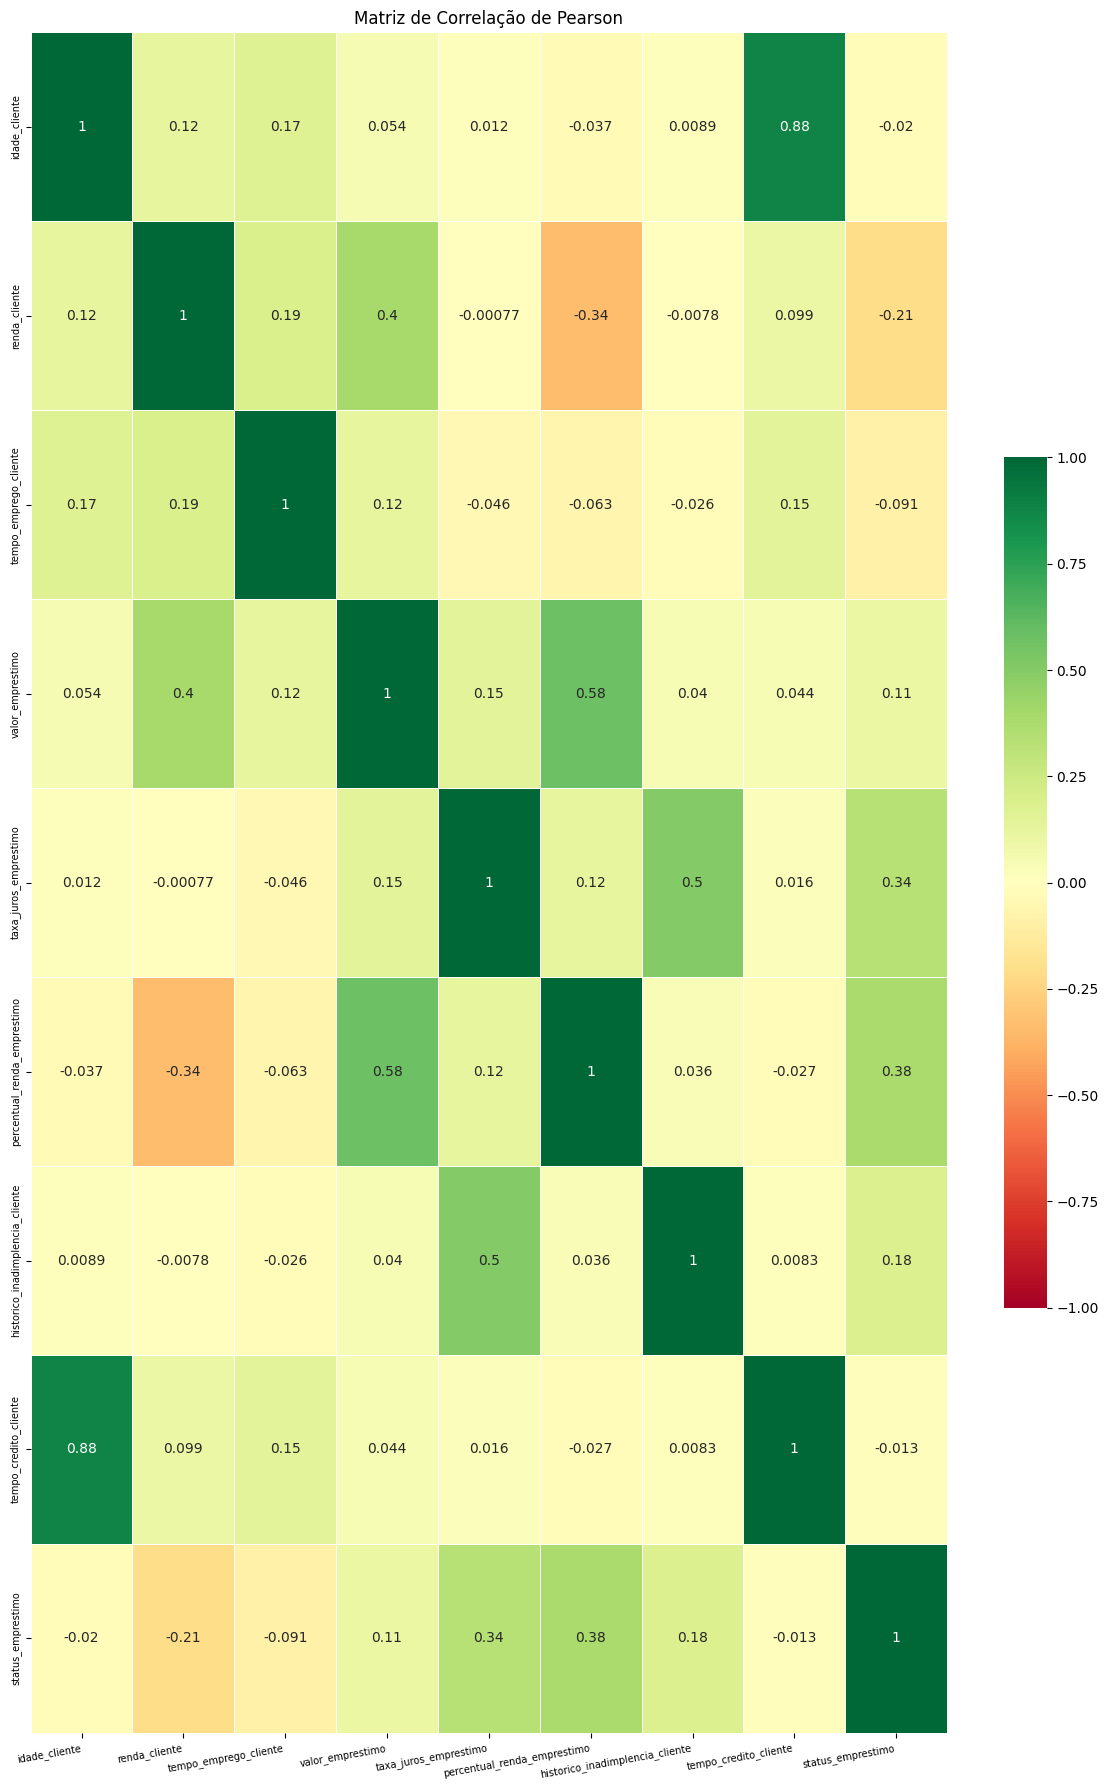

In [11]:
# Verificando a Correlação de Pearson para as variáveis do dataset
plt.figure(figsize=(12,18))
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calcular a matriz da correlação de Pearson
corr_matrix = df[numeric_cols].corr()

# Exibindo a correlação de Pearson e ajustando os rótulos
sns.heatmap(data=corr_matrix,annot=True, cmap='RdYlGn', vmin=-1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=10, ha='right', fontsize=7)
plt.yticks(rotation=90, fontsize=7)
plt.title('Matriz de Correlação de Pearson')
plt.tight_layout()
plt.show();

Podemos observar uma correlação positiva moderada entre as variáveis:
- **`idade_cliente`** e **`tempo_credito_cliente`**; e
- **`taxa_juros_emprestimo`** e **`historico_inadimplencia_cliente`**

### Avaliando a performance de modelos e respectivas Feature Importances

In [6]:
# Separamos a variável dependente das independentes
X = df.drop(columns = ["status_emprestimo"], axis = 1)
y = df['status_emprestimo']

Instanciamos a variável target e as variáveis independentes.

In [6]:
# Definindo o peso das classes
peso_classe0 = (22956 + 6459) / (2*22956)
peso_classe1 = (22956 + 6459) / (2*6459)
pesos = {0: peso_classe0, 1: peso_classe1}
print(peso_classe0, peso_classe1)

0.6406821745948772 2.2770552717138877


Como a Classe 1 é rara, o modelo Random Forest precisa que seja instanciado a proporção inversa de cada classe, definindo o peso de cada uma.
- Classe 0 -> Peso: 0.6406821745948772
- Classe 1  -> Peso: 2.2770552717138877

Média da Precisão (Weighted): 93.62%
Média da Revocação (Weighted): 93.29%
Média do F1 Score (Weighted): 92.88%
Precisão x Revocação, Área abaixo da Curva: (87.66%) -> 0.8766204059272289


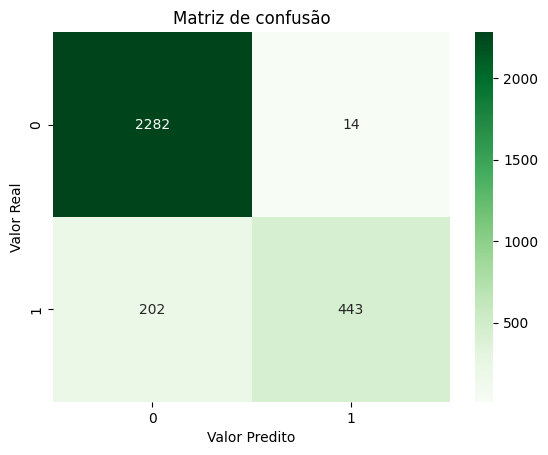

                            Feature  Importance
0                   ratio_renda_emp    0.118552
1       percentual_renda_emprestimo    0.104083
2                     renda_cliente    0.092135
3             taxa_juros_emprestimo    0.062989
4                 media_valemp_nota    0.060841
5                retorno_emprestimo    0.049686
6                   nota_emprestimo    0.046731
7               ratio_credito_renda    0.045489
8               ratio_emprego_renda    0.044191
9             finalidade_emprestimo    0.039914
10                 valor_emprestimo    0.039790
11                 media_renda_nota    0.039525
12         posse_residencia_cliente    0.034564
13            std_valemp_residencia    0.033433
14            tempo_emprego_cliente    0.030487
15            ratio_emprego_credito    0.030465
16                    idade_cliente    0.030298
17           media_renda_finalidade    0.023520
18             std_renda_residencia    0.023071
19          media_valemp_finalidade    0

In [20]:
# Instanciando o modelo random forest com 30 n_estimators, entropia como critério e pesos das classes inversamente proporcionais
randomforestclassifier = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight=pesos, random_state=47)
# Treinando o random forest classifier, exibindo métricas e feature importance
rf_treinado, _, _, _  = treinar_modelo(randomforestclassifier, X, y, True, True)

Média da Precisão (Weighted): 93.75%
Média da Revocação (Weighted): 93.47%
Média do F1 Score (Weighted): 93.09%
Precisão x Revocação, Área abaixo da Curva: (89.48%) -> 0.8947824393988443


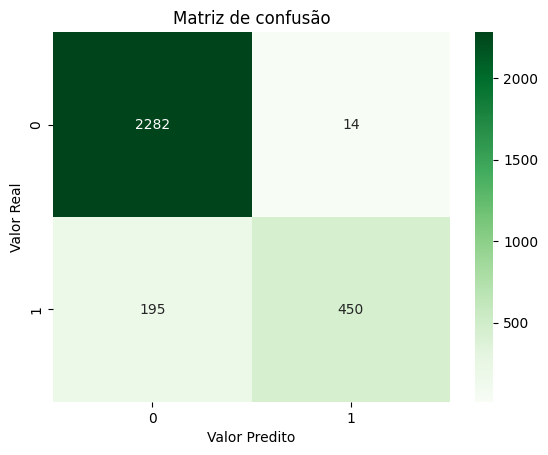

                            Feature  Importance
0                   nota_emprestimo    0.242556
1                   ratio_renda_emp    0.210923
2          posse_residencia_cliente    0.163954
3             tempo_emprego_cliente    0.098827
4             finalidade_emprestimo    0.063724
5                     renda_cliente    0.043099
6       percentual_renda_emprestimo    0.031972
7           media_valemp_finalidade    0.027222
8             taxa_juros_emprestimo    0.022481
9                     idade_cliente    0.013544
10            std_valemp_residencia    0.012352
11              ratio_emprego_renda    0.011273
12           media_renda_finalidade    0.008719
13               retorno_emprestimo    0.007232
14              ratio_credito_renda    0.007190
15            ratio_emprego_credito    0.007168
16  historico_inadimplencia_cliente    0.006771
17                 valor_emprestimo    0.005641
18            tempo_credito_cliente    0.005284
19                media_valemp_nota    0

In [7]:
# Instanciando o XGBClassifier
xgbclassifier = XGBClassifier(n_estimators=30, random_state=47)
# Treinando o xgboost, exibindo métricas e feature importance
xgboost_treinado, _, _, _  = treinar_modelo(xgbclassifier, X, y, True, True)

Média da Precisão (Weighted): 92.11%
Média da Revocação (Weighted): 91.94%
Média do F1 Score (Weighted): 91.43%
Precisão x Revocação, Área abaixo da Curva: (85.51%) -> 0.8551286144479963


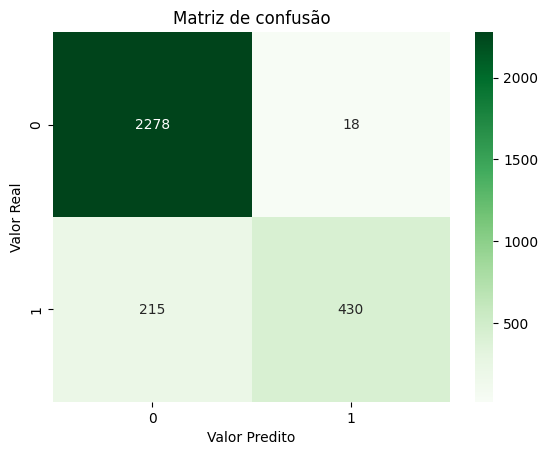

                            Feature  Importance
0                   ratio_renda_emp    0.325057
1                   nota_emprestimo    0.182328
2          posse_residencia_cliente    0.121425
3                     renda_cliente    0.098730
4                 media_valemp_nota    0.081473
5             finalidade_emprestimo    0.067084
6              std_renda_residencia    0.034581
7             std_valemp_residencia    0.029001
8             tempo_emprego_cliente    0.026668
9             taxa_juros_emprestimo    0.013293
10           media_renda_finalidade    0.007983
11      percentual_renda_emprestimo    0.005549
12                 media_renda_nota    0.003998
13          media_valemp_finalidade    0.001469
14                    idade_cliente    0.001360
15              ratio_emprego_renda    0.000000
16               retorno_emprestimo    0.000000
17            ratio_emprego_credito    0.000000
18            tempo_credito_cliente    0.000000
19  historico_inadimplencia_cliente    0

In [132]:
# Instanciando o gradient boosting
gradientboostingclassifier = GradientBoostingClassifier(n_estimators=30, random_state=47)
# treinando o gradient boosting, exibindo métricas e feature importance
gradientboost_treinado, _, _, _  = treinar_modelo(gradientboostingclassifier, X, y, True, True)

### Análise dos modelos e respectivas Features Importances
Para evitar overfitting e capturar ruídos dos dados, preferimos verificar a importância das features em cada modelo e tratar as piores posteriormente. Os modelos foram treinados com 10 folds no StratifiedKFold (SKF) em razão do desbalanceamento de classes, situação em que o SKF lida bem na distribuição de folds em treino e teste estratificando-os.
- Random Forest Classifier:
    - Média da Precisão (Weighted): 93.62%
    - Média da Revocação (Weighted): 93.29%
    - Média do F1 Score (Weighted): 92.88%
    - Precisão x Revocação, Área abaixo da Curva: 87.66%
    - Top 5 Feature Importance:
        - ratio_renda_emp;
        - percentual_renda_emprestimo;
        - renda_cliente;
        - taxa_juros_emprestimo;
        - media_valemp_nota;
    - Nenhuma feature sem importância para o modelo, sendo a menor **`historico_inadimplencia_cliente`** com 0.006285.
- XGBoost Classifier:
    - Média da Precisão (Weighted): 93.75%
    - Média da Revocação (Weighted): 93.47%
    - Média do F1 Score (Weighted): 93.09%
    - Precisão x Revocação, Área abaixo da Curva: 89.48%
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - nota_emprestimo
        - posse_residencia_cliente
        - tempo_emprego_cliente
        - finalidade_emprestimo
    - 1 feature sem importância para o modelo, sendo ela **`std_renda_residencia`**.
- Gradient Boosting Classifier:
    - Média da Precisão (Weighted): 92.11%
    - Média da Revocação (Weighted): 92.94%
    - Média do F1 Score (Weighted): 91.43%
    - Precisão x Revocação, Área abaixo da Curva: 85.51%
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - media_valemp_nota
        - nota_emprestimo
        - posse_residencia_cliente
        - renda_cliente
    - 8 features sem importância para o modelo, sendo 4 delas do DataFrame original.

O modelo que se saiu melhor em todos os aspectos foi o XGBoost Classifier obteve resultados melhores com um custo baixo de falsos positivos.

O modelo com a pior performance foi o Gradient Boosting Classifier.

 ### Feature Selection
- RFE (Recursive Feature Elimination)
    - Testamos a quantidade de features cuja métrica utilizada foi a área abaixo da curva entre precisão e revocação (pr_auc).

In [29]:
# Executando feature selection
features_RFE_randomforest = rfe_report(randomforestclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8644429061026928
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8501933327967832
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8568718411865074
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.860526228501744
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8585685289803324
----------------------------------------------
MELHOR "X_train" com 13 features:
[END] Precision Recall AUC:  0.8644429061026928
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'ratio_emprego_rend

No RandomForestClassifier obtemos o melhor resultado com 13 features e pr_auc de: 0.8644429061026928

In [12]:
# Executando feature selection
features_RFE_xgboost = rfe_report(xgbclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8952060474696704
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8956662881834732
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8942713061303631
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.89326834312437
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8932280466060128
----------------------------------------------
MELHOR "X_train" com 15 features:
[END] Precision Recall AUC:  0.8956662881834732
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota'

No XGBClassifier obtemos o melhor resultado com 15 features e pr_auc de: 0.8956662881834732

In [28]:
# Executando segundo feature selection no xgboost
_ = rfe_report(xgbclassifier, 14, 23)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8839841461487361
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.87565849436154
----------------------------------------------
RFE 18 features - [INFO] Precision Recall AUC:  0.8710990852849866
----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8769337308527267
----------------------------------------------
RFE 22 features - [INFO] Precision Recall AUC:  0.8790702149700441
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8839841461487361
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'media_valemp_f

Como o XGBoost Classifier foi o modelo que se saiu melhor nos resultados iniciais, resolvemos fazer mais uma busca nas quantidades de features restantes utilizando o RFE, obtemos um melhor resultado com 14 features e pr_auc de: 0.8956662881834732

In [133]:
# Executando segundo feature selection no gradient boosting
features_RFE_gbc = rfe_report(gradientboostingclassifier, 14, 17)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8287050807839896
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8376407331700388
----------------------------------------------
MELHOR "X_train" com 16 features:
[END] Precision Recall AUC:  0.8376407331700388
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade', 'std_renda_residencia']


No GradientBoostingClassifier obtemos o melhor resultado com 16 features e pr_auc de: 0.8376407331700388

Após verificarmos duas features acima da melhor métrica encontrada no GradientBoost, podemos confirmar que com 13 features a área abaixo da curva é maior.

### Tunagem de Hiperparâmetros
Optamos por utilizar a pesquisa bayesiana da biblioteca Optuna
- Utilizaremos as features selecionadas pelo Recursive Feature Selection.


In [46]:
# Optuna -> RandomForestClassifier
def objective(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Definindo o modelo Random Forest com hiperparâmetros da tentativa atual
    modelo = RandomForestClassifier(
        criterion='entropy',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=pesos, # peso das classes
        random_state=47
    )
    
    # Treinando o modelo com as features do RFE e exibir performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X, y, False, False, features_RFE_randomforest)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calculando a curva Precision-Recall AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Caso o score da tentativa seja muito abaixo do mais alto encontrado
    trial.report(metrica_pr_auc, step=0)
    
    # Passamos para a próxima iteração
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornando o pr_auc como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [47]:
# Registrando o tempo de início do estudo
start_time = datetime.datetime.now()

# Executando o estudo de otimização no random forest classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_random_forest = RandomForestClassifier(**study.best_params)

# Registrando o tempo de término do estudo
end_time = datetime.datetime.now()

# Calculando a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo:", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo: 4:56:35.150571
Melhores hiperparâmetros:  {'n_estimators': 277, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.6610560738295206}


In [41]:
# Optuna -> XGBoostClassifier
def objective(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # Definindo o modelo XGBoost com os hiperparâmetros da tentativa atual
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=47
    )
    
    # Treinando o modelo com as features do RFE e exibindo performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X, y, False, False, features_RFE_xgboost)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calculando a curva Precision-Recall e AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Caso o score da tentativa seja muito abaixo do mais alto encontrado
    trial.report(metrica_pr_auc, step=0)
    
    # Passamos para a próxima iteração
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o pr_auc como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [13]:
# Registrando o tempo de início do estudo
start_time = datetime.datetime.now()

# Executando o estudo de otimização no xgboost
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_xgboost = XGBClassifier(**study.best_params)

# Registrando o tempo de término do estudo
end_time = datetime.datetime.now()

# Calculando a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo:  0:04:56.773140
Melhores hiperparâmetros:  {'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.14427809782945916, 'gamma': 0.19262826608189895}


In [44]:
# Optuna -> Gradient Boosting Classifier
def objective(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    modelo = GradientBoostingClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=47
    )

    # Treinando o modelo com as features do RFE e exibindo performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X, y, False, False, features_RFE_gbc)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
 
    # Calculando a curva Precision-Recall AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Caso o score da tentativa seja muito abaixo do mais alto encontrado
    trial.report(metrica_pr_auc, step=0)
    
    # Passamos para a próxima iteração
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornando pr_auc como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [45]:
# Registrando o tempo de início do estudo
start_time = datetime.datetime.now()

# Executando o estudo de otimização no gradient boosting
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_gradient_boost = GradientBoostingClassifier(**study.best_params)

# Registrando o tempo de término do estudo
end_time = datetime.datetime.now()

# Calculando a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo:  3:27:06.995878
Melhores hiperparâmetros:  {'n_estimators': 233, 'max_depth': 7, 'learning_rate': 0.11008445645768045, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 0.9996811582073081}


### Treinando os modelos com os melhores hiperparâmetros

Média da Precisão (Weighted): 93.02%
Média da Revocação (Weighted): 92.98%
Média do F1 Score (Weighted): 92.66%
Precisão x Revocação, Área abaixo da Curva: (89.49%) -> 0.8948836001510860


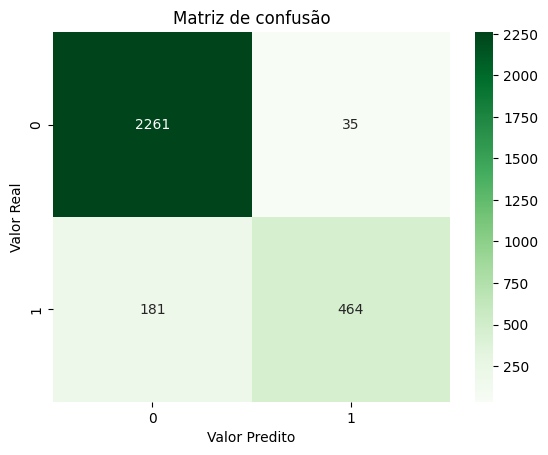

In [30]:
# Melhores hiperparâmetros:  {'n_estimators': 277, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.6610560738295206}
# treinando o random forest classifier
randomforestclassifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=277,
    max_depth=31,
    min_samples_split=4,
    min_samples_leaf=6,
    max_features=0.6610560738295206,
    class_weight=pesos,
    random_state=47
)

rf_treinado, _, _, _ = treinar_modelo(randomforestclassifier, X, y, True, False, features_RFE_randomforest)

Média da Precisão (Weighted): 93.40%
Média da Revocação (Weighted): 93.38%
Média do F1 Score (Weighted): 93.11%
Precisão x Revocação, Área abaixo da Curva: (89.79%) -> 0.8978622337162305


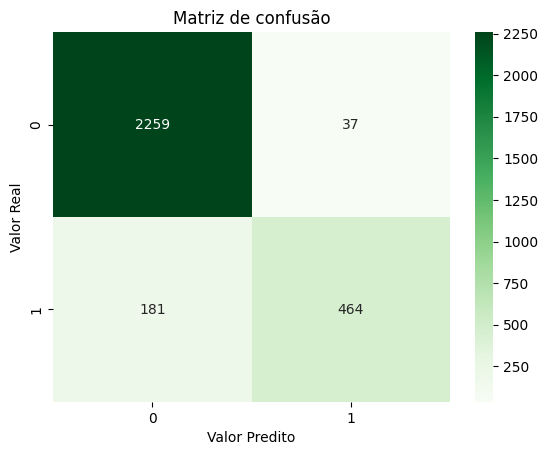

In [134]:
# Melhores hiperparâmetros: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.4112354775681158, 'gamma': 0.09972654226276964}
# treinando o xgboost classifier
xgbclassifier = XGBClassifier(
    n_estimators=227,
    max_depth=5,
    learning_rate=0.4112354775681158,
    gamma=0.09972654226276964,
    random_state=47
)

xgb_treinado, _, _, _ = treinar_modelo(xgbclassifier, X, y, True, False, features_RFE_xgboost)

Média da Precisão (Weighted): 93.81%
Média da Revocação (Weighted): 93.69%
Média do F1 Score (Weighted): 93.39%
Precisão x Revocação, Área abaixo da Curva: (90.41%) -> 0.9041163794338599


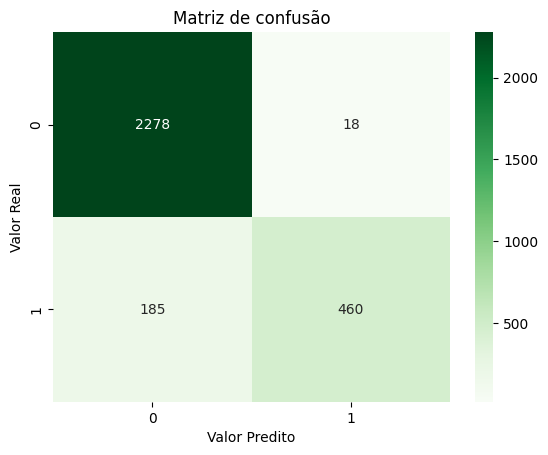

In [31]:
# Melhores hiperparâmetros:  {'n_estimators': 233, 'max_depth': 7, 'learning_rate': 0.11008445645768045, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 0.9996811582073081}
# treinando o gradient boosting classifier
gradientboostingclassifier = GradientBoostingClassifier(
    n_estimators=233,
    max_depth=7,
    learning_rate=0.11008445645768045,
    min_samples_split=13,
    min_samples_leaf=9,
    max_features=0.9996811582073081,
    random_state=47
)

gbc_treinado, _, _, _ = treinar_modelo(gradientboostingclassifier, X, y, True, False, features_RFE_gbc)

### Modelo escolhido

Em um cenário real, utilizaríamos o Gradient Boosting Classifier pelos resultados serem melhores, mas para fins didáticos e de praticidade do deply, utilizarei o XGBoost Classifier.

Escolhemos o XGBoost Classifier pelas razões abaixo:
- Possui a revocação um pouco abaixo do Gradient Boosting e identificou relativamente bem os inadimplentes. 
- Tempo de treinamento do modelo e respectiva tunagem de hiperparâmetros são rápidos, resultando em pouco tempo de atraso na resposta em deploy;
- Em produção não utiliza tanto processamento e memória; e
- O arquivo pickle do XGBoost Classifier é o mais leve.

Devemos agora, comparar o prejuízo que clientes classificados incorretamente trazem para o negócio. Para fazer isso, relembraremos do que vimos na análise exploratória em que a maior taxa de juros de empréstimo está na casa de 22.5% e o maior empréstimo fornecido é de R$ 35.000. Utilizando estes dois valores podemos verificar o quanto um **cliente inadimplente** acarreta de prejuízo a mais que um **cliente adimplente** que o modelo previu que não pagaria:

In [148]:
prejuizo_1_cliente_inadimplente = 35000
prejuizo_1_cliente_adimplente = 35000 * 0.225

proporcao_prejuizos = prejuizo_1_cliente_inadimplente / prejuizo_1_cliente_adimplente
proporcao_prejuizos

4.444444444444445

Confirmamos que a classificação errada de um cliente em potencial, porém inadimplente pode resultar no mesmo prejuízo que a classificação errada de 4 clientes em potencial que pagariam normalmente.

#### Ajuste do Limiar (Threshold)

Faremos agora um ajuste no threshold visando maximizar o lucro e utilizando do "Precision-Recall Trade-off", aumentaremos a revocação e diminuiremos a precisão, minimizando um pouco os falsos negativos, permitindo intencionalmente o aumento de Falsos Positivos e a classificação correta de Verdadeiros Negativos.

Escolhi um threshold de 0.35 após alguns testes verificando as métricas, matriz de confusão e resultados da aplicação prática do modelo no contexto do negócio:

Média da Precisão (Weighted): 92.70%
Média da Revocação (Weighted): 92.85%
Média do F1 Score (Weighted): 92.70%
Precisão x Revocação, Área abaixo da Curva: (90.68%) -> 0.9067975737717403


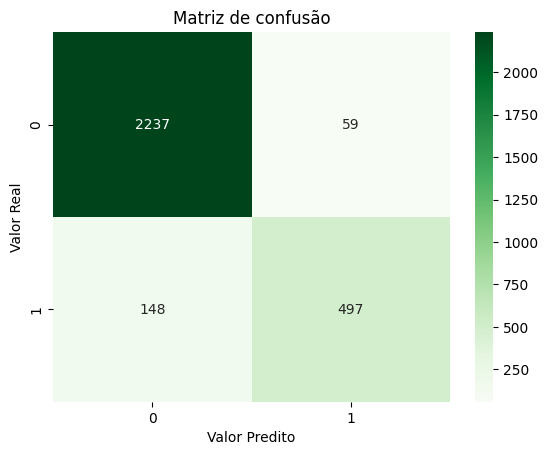

In [135]:
# Melhores hiperparâmetros: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.4112354775681158, 'gamma': 0.09972654226276964}
# treinando o xgboost classifier
xgbclassifier = XGBClassifier(
    n_estimators=227,
    max_depth=5,
    learning_rate=0.4112354775681158,
    gamma=0.09972654226276964,
    random_state=47
)

xgb_treinado_threshold, X_test, y_test, y_pred = treinar_modelo(xgbclassifier, X, y, True, False, features_RFE_xgboost, 0.35)

# Aplicação Prática de Negócio
Revisando a performance do modelo escolhido:
- **Média da Precisão (Weighted):** 92.70%
- **Média da Revocação (Weighted):** 92.85%
- **Média do F1 Score (Weighted):** 92.70%
- **Precisão x Revocação, Área abaixo da Curva:** 90.68%

O Recall nos diz que de todos os clientes que de fato não pagaram, o modelo conseguiu acertar 92.85% dos casos. Contudo, o modelo acertou apenas 92.70% dos casos em que ele previu que os clientes não pagariam.

**Inserindo em um contexto para visualizar a aplicabilidade deste modelo no negócio**
- Como não sabemos em quanto tempo um cliente pagará o empréstimo ou quanto está pagando por período, temos a proposta abaixo:

--------------------------------------------------------------------------------
Não conceder o valor de empréstimo solicitado pelos clientes inadimplentes.

--------------------------------------------------------------------------------

Para visualizar os efeitos desta proposta com esta solução utilizando machine learning devemos primeiro selecionar no banco de dados os clientes em que a previsão foi correta de clientes inadimplentes:

In [136]:
y_pred = pd.Series(y_pred)
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] == y_pred]
indices_1 = intersec[intersec == 1].index
X_test_1 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_1, :]
X_test_1

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,tempo_credito_cliente,status_emprestimo
0,22,59000,Alugada,23,Pessoal,D,35000,16.02,0.59,1,3,1
1,21,9600,Própria,5,Educação,B,1000,11.14,0.10,0,2,0
2,25,9600,Hipoteca,1,Médico,C,5500,12.87,0.57,0,3,1
4,24,54400,Alugada,8,Médico,C,35000,14.27,0.55,1,4,1
5,21,9900,Própria,2,Empreendimento,A,2500,7.14,0.25,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2925,26,51000,Alugada,3,Consolidação de Dívidas,D,3500,13.24,0.07,1,4,1
2926,26,58000,Alugada,0,Melhoria da Casa,A,3500,8.59,0.06,0,2,0
2927,24,59000,Alugada,5,Médico,A,3500,8.90,0.06,0,3,0
2932,23,36000,Hipoteca,7,Pessoal,A,7200,5.42,0.20,0,2,0


Podemos visualizar que pegamos um dos folds de teste com 498 clientes cuja previsão foram de inadimplentes.

Devemos agora verificar quanto de prejuízo evitamos, assim saberemos a eficácia da não concessão de empréstimo para estes clientes:

In [137]:
prejuizo_evitado = float((X_test_1['valor_emprestimo'].values).sum())
print(f'Evitaríamos o prejuízo de R$ {prejuizo_evitado:.2f}')

Evitaríamos o prejuízo de R$ 5022375.00


Evitamos perder R$ 5.022.375,00 (5 milhões).

Agora, podemos finalmente calcular o saldo bruto:

In [138]:
intersec = y_pred[y_test.reset_index().drop(columns='index', axis=1)['status_emprestimo'] == y_pred]
indices_2 = intersec[intersec == 0].index

# Selecionar as linhas correspondentes no dataset original df (supondo que df é o dataframe original)
X_test_2 = df.reset_index().drop(columns='index', axis=1).iloc[indices_2, :]
X_test_2

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,tempo_credito_cliente,status_emprestimo
3,23,65500,Alugada,4,Médico,C,35000,15.23,0.53,0,2,1
6,26,77100,Alugada,8,Educação,B,35000,12.42,0.45,0,3,1
7,24,78956,Alugada,5,Médico,B,35000,11.11,0.44,0,4,1
11,21,10000,Própria,2,Melhoria da Casa,A,4500,8.63,0.45,0,2,1
12,23,95000,Alugada,2,Empreendimento,A,35000,7.90,0.37,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2934,25,36000,Hipoteca,3,Médico,A,5300,7.49,0.15,0,3,0
2937,24,65000,Alugada,3,Educação,A,3500,7.74,0.05,0,3,0
2938,25,59000,Alugada,3,Médico,D,3500,15.65,0.06,0,2,1
2939,23,36000,Hipoteca,7,Consolidação de Dívidas,B,6400,11.49,0.18,0,3,0


Obtemos um dos folds de teste com 2237 clientes cuja previsão foi correta, classificando-os como adimplentes.

In [140]:
# multiplicamos o valor concedido por 1 + juros para obter o valor total que aquele cliente retornou
valor_concedido = float((X_test_2['valor_emprestimo'].values).sum())
print(f'Concedemos R$ {valor_concedido:.2f}')

Concedemos R$ 21284800.00


In [119]:
lucro_bruto = float((X_test_2['valor_emprestimo'].values*(X_test_2['taxa_juros_emprestimo'].values/100)).sum())
print(f'Obteríamos o lucro BRUTO de R$ {lucro_bruto:.2f}')

Obteríamos o lucro BRUTO de R$ 2545164.06


In [120]:
# retorno total
retorno_total = float(valor_concedido + lucro_bruto)
print(f'Retorno total das concessões de empréstimo: R$ {retorno_total:.2f}')

Retorno total das concessões de empréstimo: R$ 23829964.06


- Concedemos R$ 21.284.800.00 para os clientes (21.3 milhões)

- Nos retornou um **lucro BRUTO** de: R$ 2.545.164,06 (2.5 milhões)

- Possuímos um saldo até o momento de: R$ 23.829.964,06 (24 milhões)

Neste momento é importante verificar quanto deixaríamos de ganhar por prever erradamente os clientes que pagariam, classificando-os como inadimplentes:

In [141]:
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] != y_pred]
indices_3 = intersec[intersec == 1].index
X_test_3 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_3, :]
X_test_3

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,tempo_credito_cliente,status_emprestimo
68,22,88000,Alugada,6,Empreendimento,B,28000,9.910000,0.32,0,3,1
98,25,225000,Hipoteca,0,Melhoria da Casa,E,30000,19.910000,0.13,1,2,0
103,26,48000,Alugada,2,Educação,B,25000,9.640000,0.52,0,4,1
128,22,53000,Alugada,5,Educação,C,25000,13.430000,0.47,1,4,1
162,22,200000,Hipoteca,6,Consolidação de Dívidas,A,9000,6.170000,0.04,0,4,0
194,25,186000,Própria,9,Empreendimento,B,10000,10.250000,0.05,0,4,0
218,23,180000,Hipoteca,8,Pessoal,A,28000,7.510000,0.16,0,3,0
245,23,15000,Hipoteca,1,Médico,C,1750,12.680000,0.12,1,3,0
262,23,93000,Alugada,0,Consolidação de Dívidas,D,25000,14.590000,0.27,1,2,1
264,23,175000,Hipoteca,3,Educação,A,7200,8.380000,0.04,0,3,0


Obtemos um dos folds de teste com 37 clientes cuja previsão foi errada, classificando-os como inadimplentes.

In [142]:
# Somente o valor do empréstimo multiplicado pela taxa de juros de cada cliente
prejuizo_falsos_positivos = float((X_test_3['valor_emprestimo'].values*(X_test_3['taxa_juros_emprestimo'].values/100)).sum())
print(f'Deixaríamos de ganhar com os falsos positivos: R$ {prejuizo_falsos_positivos:.2f}')

Deixaríamos de ganhar com os falsos positivos: R$ 86028.13


Como não concederíamos empréstimos para os clientes indevidamente classificados como inadimplentes (falsos positivos), devemos somar ao prejuízo a quantia relativa ao juros sobre o empréstimo que não ganharíamos destes clientes: R$ 86.028,13 (86 mil)

Devemos agora verificar os clientes que não pagariam e foram classificados como adimplentes:

In [143]:
# Filtrar os índices dos falsos negativos
intersec = y_pred[(y_test.reset_index(drop=True) == 1) & (y_pred == 0)]
indices_4 = intersec[intersec == 0].index
X_test_4 = df.iloc[indices_4]
X_test_4

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,tempo_credito_cliente,status_emprestimo
48,23,78000,Alugada,7,Consolidação de Dívidas,F,30000,18.620001,0.38,1,3,1
71,24,83004,Alugada,0,Empreendimento,D,28000,15.990000,0.34,1,4,1
82,23,120000,Alugada,1,Educação,B,25600,12.690000,0.21,0,3,0
96,24,12960,Hipoteca,1,Melhoria da Casa,B,3650,9.910000,0.28,0,3,1
120,24,220000,Hipoteca,1,Educação,B,25000,11.580000,0.11,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2845,26,24000,Alugada,0,Empreendimento,B,3500,10.710000,0.15,0,4,0
2863,22,34000,Alugada,0,Consolidação de Dívidas,C,3500,14.270000,0.10,1,3,0
2914,22,51996,Alugada,4,Pessoal,B,3500,9.620000,0.07,0,2,0
2928,22,60000,Alugada,5,Empreendimento,A,3500,5.420000,0.06,0,2,0


Obtemos um dos folds de teste com 145 clientes cuja previsão foi errada, classificando-os como adimplentes.

In [144]:
prejuizo_falsos_negativos = float((X_test_4['valor_emprestimo'].values).sum())
print(f'Os falsos negativos resultariam em um prejuízo de R$ {prejuizo_falsos_negativos:.2f}')

Os falsos negativos resultariam em um prejuízo de R$ 1412400.00


Com os falsos negativos obtemos um prejuízo de: R$ 1.412.400,00 (1.4 milhão)

Podemos calcular o prejuízo total:

In [125]:
prejuizo_total = float(prejuizo_falsos_positivos + prejuizo_falsos_negativos)
print(f'Teríamos um prejuízo total de R% {prejuizo_total:.2f}')

Teríamos um prejuízo total de R% 1498428.13


O modelo retornou uma perda devido à classificações erradas de: R$ 1.498.428,13 (1.5 milhão)

Nesta penúltima etapa, verificamos o **total líquido**, sendo os ganhos com classificações corretas de adimplentes subtraído da classificação incorreta de clientes:

In [145]:
saldo_liquido = float(lucro_bruto - prejuizo_total)
print(f'Possuímos um total LÍQUIDO de R$ {saldo_liquido:.2f}')

Possuímos um total LÍQUIDO de R$ 1046735.93


Terminaríamos com um total líquido de: R$ 1.046.735,93 (1.1 milhão)

Agora verificaremos o nosso saldo final:

In [146]:
saldo_final = retorno_total - prejuizo_total
print(f'Possuímos um saldo final de: R$ {saldo_final:.2f}')

Possuímos um saldo final de: R$ 22331535.93


## Resultado
- Evitaríamos perder: R$ 5.022.375,00 (5 milhões).

- **Lucro Bruto** de: R$ 2.545.164,06 (2.5 milhões)

- Perderíamos: R$ 1.412.400,00 (1.4 milhão)

- Gerando um **Total Líquido** de: R$ 1.046.735,93 (1 milhão)

- No início concedemos: R$ 21.284.800.00 (21.3 milhões); e
    - Terminamos com o saldo final de R$ 22.331.535.93 (22.3 milhões)

Isso tudo com um baixo custo computacional e também com praticidade na manutenção do modelo para posterior melhorias.

O cenário ideal seria reduzir os falsos negativos à zero. Assim o número de falsos positivos aumentarão substancialmente ao diminuir o threshold, gerando perdas significativas de dinheiro, entretanto, vimos anteriormente que o prejuízo que a classificação errada de um cliente que de fato será inadimplente é quatro vezes maior que de um cliente que pagaria sendo classificado como inadimplente. Com o nosso ajuste do threshold, o modelo agora abrange um pouco mais este prejuízo dos Falsos Negativos.

## Exportando o modelo final

In [149]:
# Serializando o modelo em um arquivo pickle
with open(f'xgboostclassifier-{str(datetime.date.today())}.pkl', mode='wb') as f:
    pickle.dump(xgb_treinado, f)